In [32]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.datasets as Datasets
import torchvision.transforms as transforms
import torch.nn.functional as F
import torchvision.utils as vutils

import matplotlib.pyplot as plt
from tqdm import tqdm

In [33]:
batch_size = 64

# Define learning rate
lr = 1e-4

# Number of Training epochs
nepoch = 10

# Dataset location
root = "../data"

# Scale for the added image noise
noise_scale = 0.3

In [34]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available() else "cpu"
)
device

'mps'

In [35]:
# Define our transform
# We'll upsample the images to 32x32 as it's easier to contruct our network
transform = transforms.Compose(
    [transforms.Resize(32), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]
)

train_set = Datasets.MNIST(root=root, train=True, transform=transform, download=True)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=4)

test_set = Datasets.MNIST(root=root, train=False, transform=transform, download=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=4)

In [36]:
class Encoder(nn.Module):
    def __init__(
        self,
        channels,  # Number of channels in the input image
        ch: int = 32,  # Number of channels in the first convolutional layer
        z: int = 32,  # Dimension of the latent space
    ):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(channels, ch, 3, stride=2, padding=1)
        self.bn1 = nn.BatchNorm2d(ch)
        self.conv2 = nn.Conv2d(ch, ch * 2, 3, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(ch * 2)
        self.conv3 = nn.Conv2d(ch * 2, ch * 4, 3, stride=2, padding=1)
        self.bn3 = nn.BatchNorm2d(ch * 4)

        self.conv_out = nn.Conv2d(ch * 4, z, 4, stride=1)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        return self.conv_out(x)

In [37]:
class Decoder(nn.Module):
    def __init__(self, channels, ch: int = 32, z: int = 32):
        super(Decoder, self).__init__()

        self.conv1 = nn.ConvTranspose2d(z, ch * 4, 4, stride=1)
        self.bn1 = nn.BatchNorm2d(ch * 4)
        self.conv2 = nn.ConvTranspose2d(
            ch * 4, ch * 2, 3, stride=2, padding=1, output_padding=1
        )
        self.bn2 = nn.BatchNorm2d(ch * 2)
        self.conv3 = nn.ConvTranspose2d(
            ch * 2, ch, 3, stride=2, padding=1, output_padding=1
        )
        self.bn3 = nn.BatchNorm2d(ch)
        self.conv4 = nn.ConvTranspose2d(
            ch, ch, 3, stride=2, padding=1, output_padding=1
        )
        self.bn4 = nn.BatchNorm2d(ch)

        self.conv_out = nn.Conv2d(
            ch, channels, 3, stride=1, padding=1
        )  # padding=1 to remove the black border in the output

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        return torch.tanh(self.conv_out(x))

In [38]:
class AE(nn.Module):
    def __init__(self, channel_in, ch: int = 16, z: int = 32):
        super(AE, self).__init__()
        self.encoder = Encoder(channel_in, ch, z)
        self.decoder = Decoder(channel_in, ch, z)

    def forward(self, x):
        encoded = self.encoder(x)
        x = self.decoder(encoded)
        return x, encoded

In [39]:
# Get a test image
test_images, _ = next(iter(test_loader))
test_images.shape

torch.Size([64, 1, 32, 32])

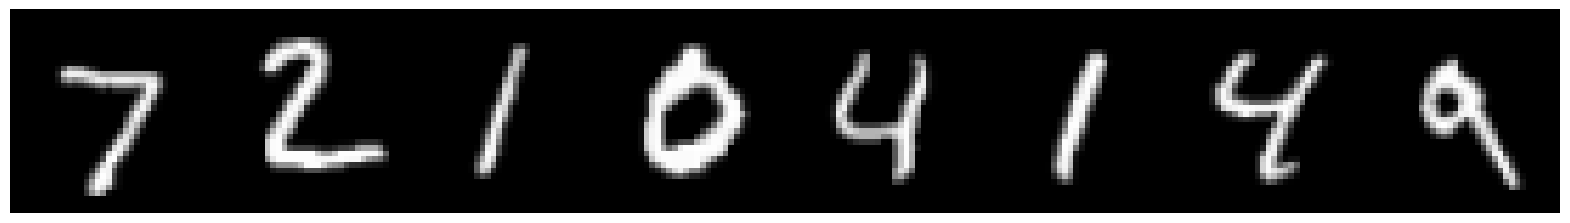

In [40]:
plt.figure(figsize=(20, 10))
plt.axis("off")
out = vutils.make_grid(test_images[0:8], normalize=True)
_ = plt.imshow(out.numpy().transpose((1, 2, 0)))

### De-noising Autoencoder for MNIST

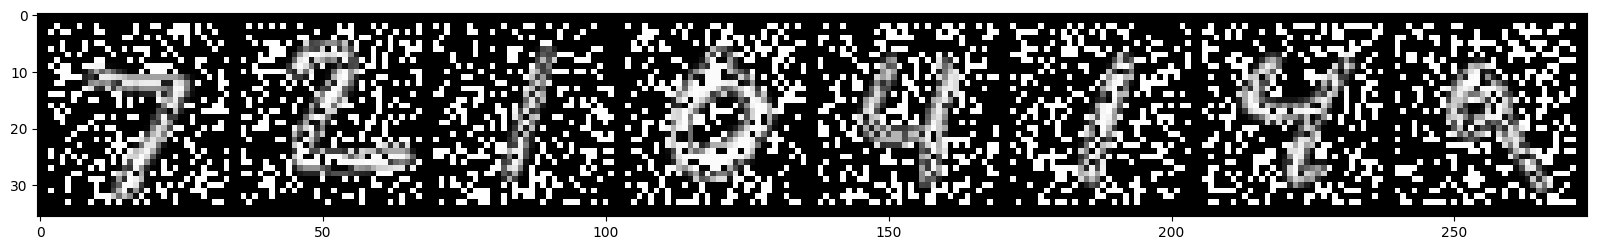

In [41]:
plt.figure(figsize=(20, 10))
random_sample = (
    torch.bernoulli((1 - noise_scale) * torch.ones_like(test_images)) * 2
) - 1
noisy_test_img = random_sample * test_images

out = vutils.make_grid(noisy_test_img[0:8], normalize=True)
_ = plt.imshow(out.numpy().transpose((1, 2, 0)))

### Create Network and Optimizer

In [42]:
latent_size = 128  # Size of the latent space

# Create the model
ae_net = AE(channel_in=1, z=latent_size).to(device)

# Define the optimizer
optimizer = optim.Adam(ae_net.parameters(), lr=lr)

# Define the loss function for reconstruction
criterion = nn.MSELoss()

loss_log = []
train_loss = 0

In [43]:
# Network output
recon_data, encoded = ae_net(test_images.to(device))

# View the shape of the Latent space -> [batch_size, latent_size, 1, 1]
encoded.shape

torch.Size([64, 128, 1, 1])

In [44]:
# Train the model
for epoch in tqdm(range(nepoch), desc="Epochs"):
    train_loss = 0
    for i, data in enumerate(tqdm(train_loader, desc="Training")):
        image = data[0].to(device)

        random_sample = (
            torch.bernoulli((1 - noise_scale) * torch.ones_like(image)) * 2
        ) - 1
        noisy_image = random_sample * image

        recon_data, _ = ae_net(noisy_image)
        loss = criterion(recon_data, image)

        loss_log.append(loss.item())
        train_loss

        ae_net.zero_grad()
        loss.backward()
        optimizer.step()






































































































































































































































































































































































































































































Training: 100%|██████████| 938/938 [00:19<00:00, 48.76it/s]
























































































































































































































































































































































































































Training: 100%|██████████| 938/938 [00:17<00:00, 54.35it/s]





















Text(0.5, 1.0, 'MSE Loss')

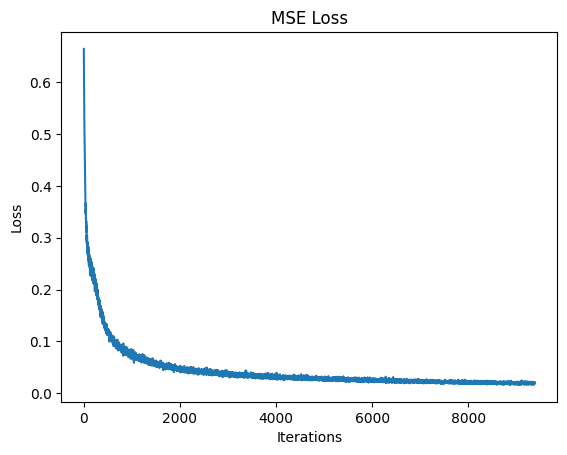

In [50]:
plt.plot(loss_log)
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("MSE Loss")

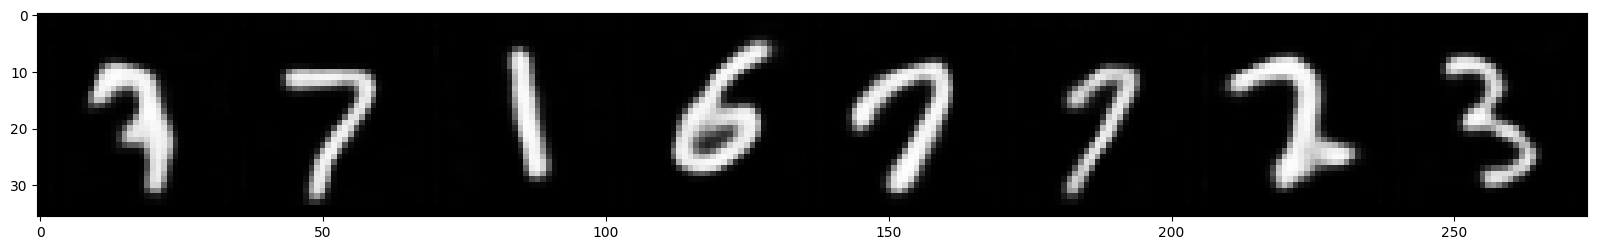

In [46]:
plt.figure(figsize=(20, 10))
out = vutils.make_grid(recon_data[0:8], normalize=True)
_ = plt.imshow(out.cpu().detach().numpy().transpose((1, 2, 0)))

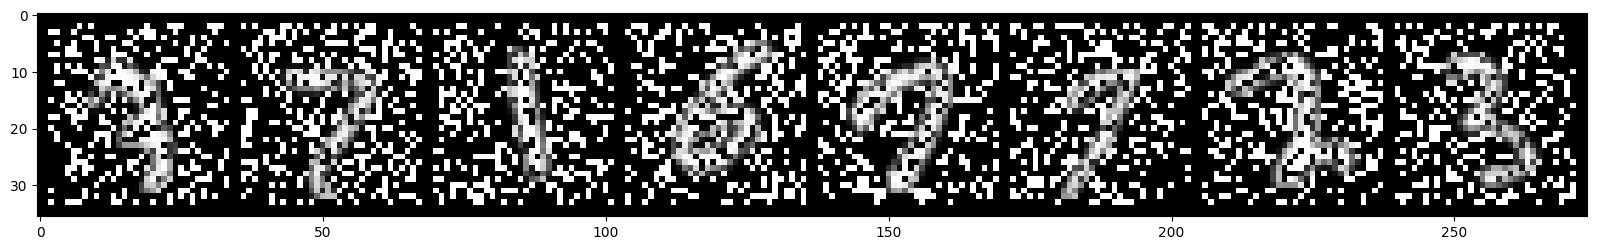

In [47]:
# Noisy Input
plt.figure(figsize=(20, 10))
out = vutils.make_grid(noisy_image[0:8], normalize=True)
_ = plt.imshow(out.cpu().detach().numpy().transpose((1, 2, 0)))

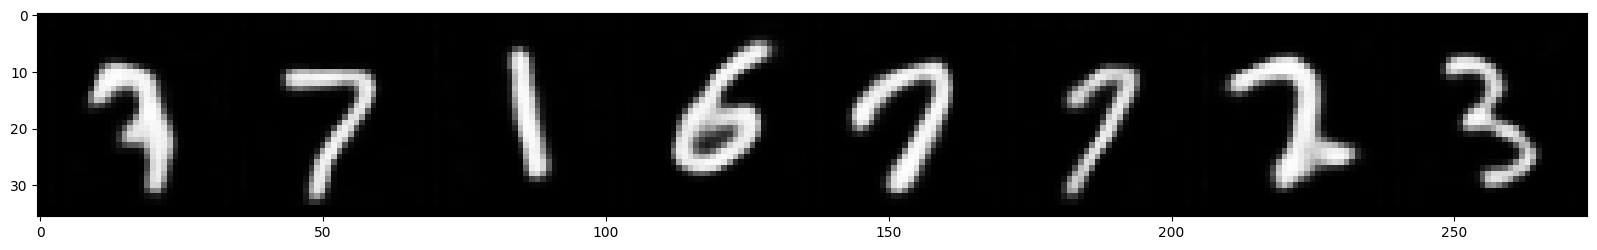

In [48]:
# Reconstruction
plt.figure(figsize=(20, 10))
recon_data, _ = ae_net(noisy_image.to(device))
out = vutils.make_grid(recon_data.detach().cpu()[0:8], normalize=True)
_ = plt.imshow(out.numpy().transpose((1, 2, 0)))

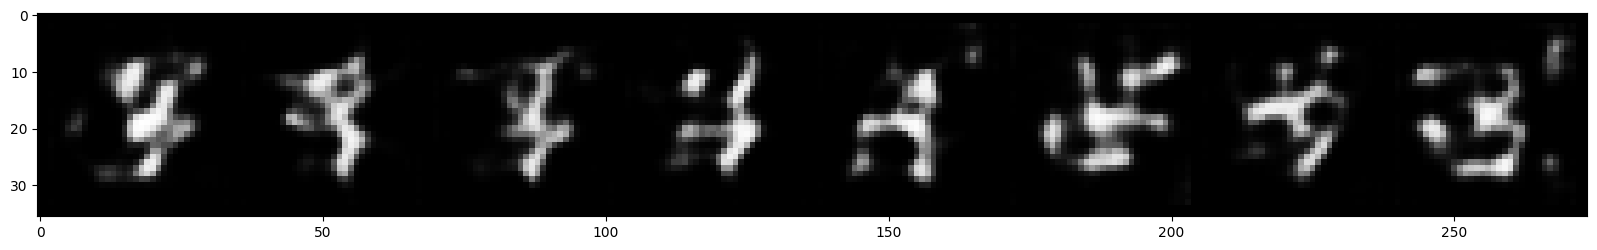

In [49]:
# Reconstruction (based on the mean of the latent space distribution)
plt.figure(figsize=(20, 10))
recon_data = ae_net.decoder(
    encoded.std(0, keepdims=True) * torch.randn_like(encoded)
    + encoded.mean(0, keepdims=True)
)
out = vutils.make_grid(recon_data.detach().cpu()[0:8], normalize=True)
_ = plt.imshow(out.numpy().transpose((1, 2, 0)))